# Flower Recognition with ResNet

In [ ]:
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu
Using device: cpu


In [ ]:
#setting up data loading and preprocessing
import os
import scipy.io
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data directories
data_dir = 'data/flowers-102'
images_dir = os.path.join(data_dir, 'jpg')

# Load mat files for labels and train/val/test splits
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0] - 1  # Convert to 0-based indexing
splits = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))

# Get indices for train, val, and test sets
train_idx = splits['trnid'][0] - 1  # Convert to 0-based indexing
val_idx = splits['valid'][0] - 1
test_idx = splits['tstid'][0] - 1

class Flowers102Dataset(Dataset):
    def __init__(self, image_dir, indices, labels, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_name = f'image_{img_idx+1:05d}.jpg'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[img_idx]
        return image, label

#define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#create datasets
train_dataset = Flowers102Dataset(images_dir, train_idx, labels, train_transform)
val_dataset = Flowers102Dataset(images_dir, val_idx, labels, val_test_transform)
test_dataset = Flowers102Dataset(images_dir, test_idx, labels, val_test_transform)

#create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

#store dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Dataset sizes:")
print(f"Training: {dataset_sizes['train']} images")
print(f"Validation: {dataset_sizes['val']} images")
print(f"Test: {dataset_sizes['test']} images")

Dataset sizes:
Training: 1020 images
Validation: 1020 images
Test: 6149 images


Training samples:


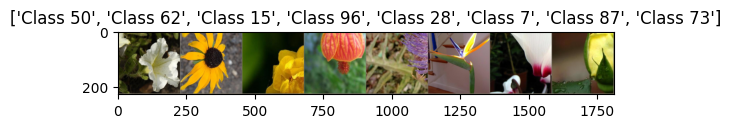

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#visualise some training images
def visualize_samples(dataloader, num_images=8):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[f'Class {x}' for x in classes[:num_images]])

print("Training samples:")
visualize_samples(dataloaders['train'])

In [ ]:
#base ResNet Model
class FlowerResNet(nn.Module):
    def __init__(self, base_model='resnet18', pretrained=True, num_classes=102):
        super(FlowerResNet, self).__init__()
        
        if base_model == 'resnet18':
            if pretrained:
                self.backbone = models.resnet18(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet18(weights=None)
        elif base_model == 'resnet34':
            if pretrained:
                self.backbone = models.resnet34(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet34(weights=None)
        else:
            raise ValueError("Unsupported base model")
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

# Model with Frozen Stages
class FlowerResNetFrozen(nn.Module):
    def __init__(self, base_model='resnet18', num_frozen_stages=3, num_classes=102):
        super(FlowerResNetFrozen, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        elif base_model == 'resnet34':
            self.backbone = models.resnet34(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Unsupported base model")
        
        # Freeze specified stages
        self._freeze_stages(num_frozen_stages)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _freeze_stages(self, num_stages):
        """Freeze the first num_stages of ResNet"""
        if num_stages >= 1:
            for param in self.backbone.conv1.parameters():
                param.requires_grad = False
            for param in self.backbone.bn1.parameters():
                param.requires_grad = False
        if num_stages >= 2:
            for param in self.backbone.layer1.parameters():
                param.requires_grad = False
        if num_stages >= 3:
            for param in self.backbone.layer2.parameters():
                param.requires_grad = False
        if num_stages >= 4:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        if num_stages >= 5:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        return self.backbone(x)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='resnet18'):
    since = time.time()
    
    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')
    
    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        #each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #iterating over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            #calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            #store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            #save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_losses, train_accs, val_losses, val_accs

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    #plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    #plot accuracies
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')
                
                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()
    
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

### Experiment 3 resnet-34 with 3 frozen stages 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/UG/rishika004/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 256MB/s]



ResNet34 - Trainable parameters: 19989094/21336998 (93.68%)
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=4.4086, Acc=0.0714]


train Loss: 4.7367 Acc: 0.0216


Val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, Loss=4.3519, Acc=0.1071]



val Loss: 4.3275 Acc: 0.0765
New best model saved with val_acc: 0.0765

Epoch 1/49
----------
New best model saved with val_acc: 0.0765

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s, Loss=3.9253, Acc=0.2143]


train Loss: 4.1263 Acc: 0.1461


Val Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s, Loss=3.6771, Acc=0.5000]



val Loss: 3.7296 Acc: 0.3078
New best model saved with val_acc: 0.3078

Epoch 2/49
----------
New best model saved with val_acc: 0.3078

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s, Loss=3.4327, Acc=0.3929]


train Loss: 3.5573 Acc: 0.3922


Val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s, Loss=2.8522, Acc=0.5714]



val Loss: 3.1110 Acc: 0.5216
New best model saved with val_acc: 0.5216

Epoch 3/49
----------
New best model saved with val_acc: 0.5216

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s, Loss=2.9110, Acc=0.5357]


train Loss: 2.9830 Acc: 0.5706


Val Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, Loss=2.0972, Acc=0.6786]



val Loss: 2.5573 Acc: 0.6343
New best model saved with val_acc: 0.6343

Epoch 4/49
----------
New best model saved with val_acc: 0.6343

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s, Loss=2.2655, Acc=0.7143]


train Loss: 2.5108 Acc: 0.6745


Val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=1.6222, Acc=0.7500]



val Loss: 2.1061 Acc: 0.7088
New best model saved with val_acc: 0.7088

Epoch 5/49
----------
New best model saved with val_acc: 0.7088

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s, Loss=2.1510, Acc=0.6429]


train Loss: 2.1006 Acc: 0.7402


Val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, Loss=1.3847, Acc=0.7143]



val Loss: 1.7668 Acc: 0.7520
New best model saved with val_acc: 0.7520

Epoch 6/49
----------
New best model saved with val_acc: 0.7520

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, Loss=1.9463, Acc=0.6786]


train Loss: 1.7943 Acc: 0.7882


Val Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=1.0446, Acc=0.8214]



val Loss: 1.4938 Acc: 0.7843
New best model saved with val_acc: 0.7843

Epoch 7/49
----------
New best model saved with val_acc: 0.7843

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s, Loss=1.7804, Acc=0.7143]


train Loss: 1.5112 Acc: 0.8392


Val Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.9478, Acc=0.8571]



val Loss: 1.2856 Acc: 0.8127
New best model saved with val_acc: 0.8127

Epoch 8/49
----------
New best model saved with val_acc: 0.8127

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=1.1854, Acc=0.8571]


train Loss: 1.2951 Acc: 0.8637


Val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.7788, Acc=0.8571]



val Loss: 1.1327 Acc: 0.8412
New best model saved with val_acc: 0.8412

Epoch 9/49
----------
New best model saved with val_acc: 0.8412

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.9455, Acc=0.8571]


train Loss: 1.1265 Acc: 0.8824


Val Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, Loss=0.6958, Acc=0.9643]



val Loss: 1.0027 Acc: 0.8588
New best model saved with val_acc: 0.8588

Epoch 10/49
----------
New best model saved with val_acc: 0.8588

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.8569, Acc=0.9286]


train Loss: 0.9647 Acc: 0.9098


Val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, Loss=0.7184, Acc=0.9286]



val Loss: 0.8990 Acc: 0.8676
New best model saved with val_acc: 0.8676

Epoch 11/49
----------
New best model saved with val_acc: 0.8676

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, Loss=0.8025, Acc=0.8929]


train Loss: 0.8889 Acc: 0.9010


Val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.07it/s, Loss=0.5776, Acc=1.0000]



val Loss: 0.8131 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 12/49
----------
New best model saved with val_acc: 0.8735

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.8111, Acc=0.9643]


train Loss: 0.7839 Acc: 0.9147


Val Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, Loss=0.5863, Acc=0.9286]



val Loss: 0.7468 Acc: 0.8765
New best model saved with val_acc: 0.8765

Epoch 13/49
----------
New best model saved with val_acc: 0.8765

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.6988, Acc=0.8571]


train Loss: 0.7007 Acc: 0.9225


Val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  5.25it/s, Loss=0.5212, Acc=1.0000]



val Loss: 0.7004 Acc: 0.8902
New best model saved with val_acc: 0.8902

Epoch 14/49
----------
New best model saved with val_acc: 0.8902

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, Loss=0.5526, Acc=0.9643]


train Loss: 0.6493 Acc: 0.9353


Val Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, Loss=0.4533, Acc=1.0000]



val Loss: 0.6530 Acc: 0.8990
New best model saved with val_acc: 0.8990

Epoch 15/49
----------
New best model saved with val_acc: 0.8990

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s, Loss=0.7397, Acc=0.9286]


train Loss: 0.5764 Acc: 0.9294


Val Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=0.3829, Acc=1.0000]


val Loss: 0.6184 Acc: 0.8961

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.5510, Acc=0.9286]


train Loss: 0.5184 Acc: 0.9461


Val Epoch 16: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s, Loss=0.3980, Acc=1.0000]


val Loss: 0.5857 Acc: 0.8990

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.7777, Acc=0.8571]


train Loss: 0.5073 Acc: 0.9373


Val Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s, Loss=0.3947, Acc=1.0000]



val Loss: 0.5542 Acc: 0.9059
New best model saved with val_acc: 0.9059

Epoch 18/49
----------
New best model saved with val_acc: 0.9059

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.2886, Acc=0.9643]


train Loss: 0.4347 Acc: 0.9539


Val Epoch 18: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, Loss=0.3669, Acc=1.0000]



val Loss: 0.5334 Acc: 0.9069
New best model saved with val_acc: 0.9069

Epoch 19/49
----------
New best model saved with val_acc: 0.9069

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s, Loss=0.3709, Acc=0.9643]


train Loss: 0.3791 Acc: 0.9618


Val Epoch 19: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s, Loss=0.3951, Acc=1.0000]



val Loss: 0.5128 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 20/49
----------
New best model saved with val_acc: 0.9137

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s, Loss=0.4091, Acc=0.9643]


train Loss: 0.3970 Acc: 0.9539


Val Epoch 20: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s, Loss=0.3201, Acc=1.0000]


val Loss: 0.4954 Acc: 0.9127

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.3928, Acc=0.9643]


train Loss: 0.4147 Acc: 0.9402


Val Epoch 21: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.2590, Acc=1.0000]


val Loss: 0.4771 Acc: 0.9118

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s, Loss=0.3735, Acc=0.9643]


train Loss: 0.3748 Acc: 0.9578


Val Epoch 22: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s, Loss=0.2262, Acc=1.0000]



val Loss: 0.4734 Acc: 0.9147
New best model saved with val_acc: 0.9147

Epoch 23/49
----------
New best model saved with val_acc: 0.9147

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s, Loss=0.1860, Acc=1.0000]


train Loss: 0.3500 Acc: 0.9520


Val Epoch 23: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s, Loss=0.3042, Acc=1.0000]



val Loss: 0.4510 Acc: 0.9206
New best model saved with val_acc: 0.9206

Epoch 24/49
----------
New best model saved with val_acc: 0.9206

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s, Loss=0.2547, Acc=1.0000]


train Loss: 0.3320 Acc: 0.9549


Val Epoch 24: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s, Loss=0.2980, Acc=1.0000]



val Loss: 0.4398 Acc: 0.9235
New best model saved with val_acc: 0.9235

Epoch 25/49
----------
New best model saved with val_acc: 0.9235

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s, Loss=0.5362, Acc=0.9286]


train Loss: 0.3166 Acc: 0.9598


Val Epoch 25: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s, Loss=0.2829, Acc=1.0000]



val Loss: 0.4313 Acc: 0.9245
New best model saved with val_acc: 0.9245

Epoch 26/49
----------
New best model saved with val_acc: 0.9245

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s, Loss=0.2551, Acc=0.9643]


train Loss: 0.2842 Acc: 0.9676


Val Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s, Loss=0.2139, Acc=1.0000]


val Loss: 0.4219 Acc: 0.9235

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.3153, Acc=0.9643]


train Loss: 0.2494 Acc: 0.9706


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s, Loss=0.2030, Acc=1.0000]


val Loss: 0.4135 Acc: 0.9225

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, Loss=0.1560, Acc=1.0000]


train Loss: 0.2427 Acc: 0.9676


Val Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.1819, Acc=1.0000]


val Loss: 0.4088 Acc: 0.9225

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.3165, Acc=0.9286]


train Loss: 0.2460 Acc: 0.9686


Val Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, Loss=0.2178, Acc=1.0000]



val Loss: 0.4028 Acc: 0.9265
New best model saved with val_acc: 0.9265

Epoch 30/49
----------
New best model saved with val_acc: 0.9265

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, Loss=0.2166, Acc=0.9643]


train Loss: 0.2237 Acc: 0.9735


Val Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s, Loss=0.2181, Acc=1.0000]



val Loss: 0.3938 Acc: 0.9275
New best model saved with val_acc: 0.9275

Epoch 31/49
----------
New best model saved with val_acc: 0.9275

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.3739, Acc=0.9286]


train Loss: 0.2246 Acc: 0.9735


Val Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.2165, Acc=1.0000]



val Loss: 0.3917 Acc: 0.9304
New best model saved with val_acc: 0.9304

Epoch 32/49
----------
New best model saved with val_acc: 0.9304

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s, Loss=0.2449, Acc=0.9643]


train Loss: 0.2259 Acc: 0.9765


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, Loss=0.2182, Acc=1.0000]


val Loss: 0.3972 Acc: 0.9284

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s, Loss=0.5282, Acc=0.9286]


train Loss: 0.2530 Acc: 0.9716


Val Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, Loss=0.2152, Acc=1.0000]


val Loss: 0.3918 Acc: 0.9275

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s, Loss=0.4246, Acc=0.9286]


train Loss: 0.2146 Acc: 0.9775


Val Epoch 34: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.2238, Acc=1.0000]


val Loss: 0.3920 Acc: 0.9245

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s, Loss=0.2680, Acc=1.0000]


train Loss: 0.2433 Acc: 0.9706


Val Epoch 35: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s, Loss=0.2137, Acc=1.0000]


val Loss: 0.3948 Acc: 0.9294

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s, Loss=0.1388, Acc=1.0000]


train Loss: 0.2418 Acc: 0.9716


Val Epoch 36: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s, Loss=0.2099, Acc=1.0000]


val Loss: 0.3918 Acc: 0.9284

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s, Loss=0.1522, Acc=0.9643]


train Loss: 0.2309 Acc: 0.9647


Val Epoch 37: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s, Loss=0.1909, Acc=1.0000]


val Loss: 0.3912 Acc: 0.9265

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s, Loss=0.1455, Acc=1.0000]


train Loss: 0.2565 Acc: 0.9637


Val Epoch 38: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, Loss=0.1925, Acc=1.0000]


val Loss: 0.3888 Acc: 0.9235

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, Loss=0.1021, Acc=1.0000]


train Loss: 0.1984 Acc: 0.9853


Val Epoch 39: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2301, Acc=1.0000]


val Loss: 0.3997 Acc: 0.9284

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s, Loss=0.1916, Acc=0.9643]


train Loss: 0.2518 Acc: 0.9647


Val Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2156, Acc=1.0000]


val Loss: 0.3890 Acc: 0.9275

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s, Loss=0.4049, Acc=0.8929]


train Loss: 0.2293 Acc: 0.9735


Val Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, Loss=0.2023, Acc=1.0000]


val Loss: 0.3861 Acc: 0.9245

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.1558, Acc=1.0000]


train Loss: 0.2315 Acc: 0.9716


Val Epoch 42: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s, Loss=0.1922, Acc=1.0000]


val Loss: 0.3877 Acc: 0.9255

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.1784, Acc=0.9643]


train Loss: 0.2372 Acc: 0.9706


Val Epoch 43: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.1947, Acc=1.0000]


val Loss: 0.3903 Acc: 0.9284

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:16<00:00,  2.00it/s, Loss=0.3426, Acc=0.9643]


train Loss: 0.2179 Acc: 0.9706


Val Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.1964, Acc=1.0000]


val Loss: 0.3809 Acc: 0.9284

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s, Loss=0.2886, Acc=0.9643]


train Loss: 0.2316 Acc: 0.9686


Val Epoch 45: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.2037, Acc=1.0000]


val Loss: 0.3815 Acc: 0.9265

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s, Loss=0.2651, Acc=0.9643]


train Loss: 0.2113 Acc: 0.9735


Val Epoch 46: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, Loss=0.2126, Acc=1.0000]


val Loss: 0.3850 Acc: 0.9304

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s, Loss=0.2571, Acc=0.9643]


train Loss: 0.2456 Acc: 0.9676


Val Epoch 47: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=0.2107, Acc=1.0000]


val Loss: 0.3822 Acc: 0.9304

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, Loss=0.3086, Acc=0.9643]


train Loss: 0.2408 Acc: 0.9676


Val Epoch 48: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s, Loss=0.1999, Acc=1.0000]



val Loss: 0.3869 Acc: 0.9314
New best model saved with val_acc: 0.9314

Epoch 49/49
----------
New best model saved with val_acc: 0.9314

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s, Loss=0.1008, Acc=1.0000]


train Loss: 0.2144 Acc: 0.9716


Val Epoch 49: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2037, Acc=1.0000]



val Loss: 0.3839 Acc: 0.9294

Training complete in 17m 7s
Best val Acc: 0.931373


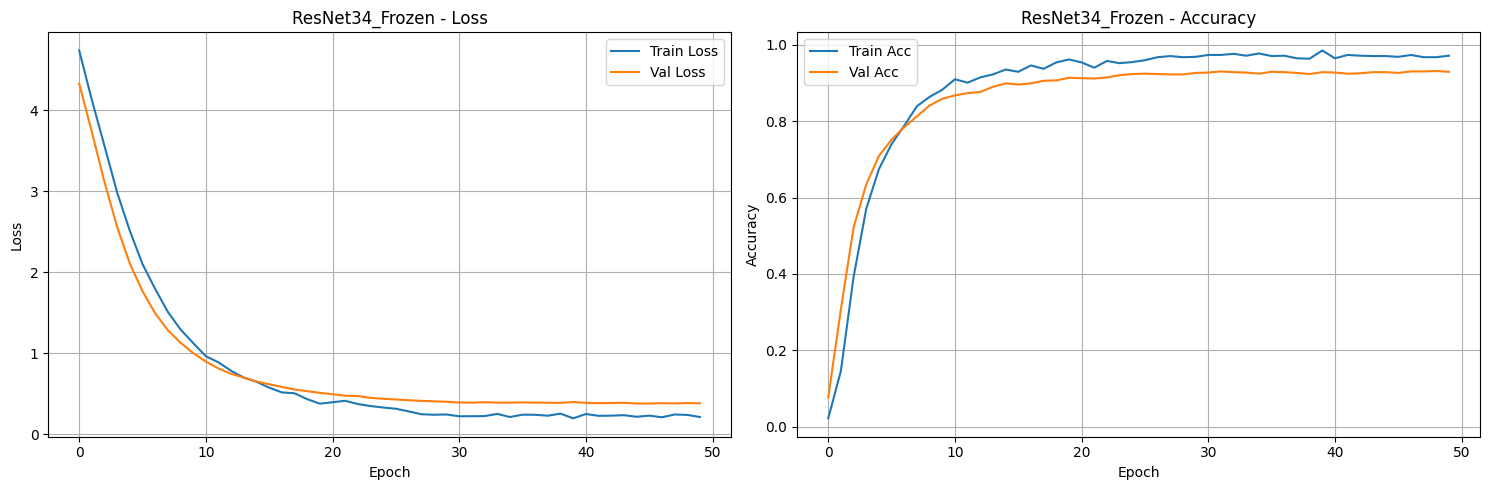

Evaluating on test set...


100%|██████████| 193/193 [00:36<00:00,  5.25it/s]

Test Loss: 0.4596
Test Accuracy: 0.9000
ResNet34 Frozen - Test Accuracy: 0.9000


In [ ]:

#create ResNet-34 model with three frozen stages
model_resnet34 = FlowerResNetFrozen(base_model='resnet34', num_frozen_stages=3, num_classes=102)
model_resnet34 = model_resnet34.to(device)
num_epochs = 50
criterion = nn.CrossEntropyLoss()

#count parameters
trainable_params_34 = sum(p.numel() for p in model_resnet34.parameters() if p.requires_grad)
total_params_34 = sum(p.numel() for p in model_resnet34.parameters())
print(f"ResNet34 - Trainable parameters: {trainable_params_34}/{total_params_34} ({trainable_params_34/total_params_34*100:.2f}%)")

#defining optimizer
optimizer_34 = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34.parameters()), 
    lr=0.001, momentum=0.9
)
scheduler_34 = lr_scheduler.StepLR(optimizer_34, step_size=30, gamma=0.1)

#training model
model_resnet34, train_losses_34, train_accs_34, val_losses_34, val_accs_34 = train_model(
    model_resnet34, criterion, optimizer_34, scheduler_34, num_epochs, 'resnet34_frozen'
)

plot_training_curves(train_losses_34, val_losses_34, train_accs_34, val_accs_34, 'ResNet34_Frozen')

test_loss_34, test_acc_34, all_preds_34, all_labels_34 = evaluate_model(model_resnet34, criterion)

#save the training logs
with open('resnet34_frozen.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_34[epoch]:.4f},{val_losses_34[epoch]:.4f},{train_accs_34[epoch]:.4f},{val_accs_34[epoch]:.4f}\n")

print(f"ResNet34 Frozen - Test Accuracy: {test_acc_34:.4f}")